The [simple_pipeline notebook](./simple_pipeline.ipynb) covered the basic use of the `fairret` library. Now, we'll dive a bit deeper into the sensitive features tensor, including a mix of discrete and continuous features.

We'll skim over the data loading and model definition this time.

# Data prep

In [35]:
from folktables import ACSDataSource, ACSIncome, generate_categories

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
data = data_source.get_data(states=["CA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(data, categories=categories, dummies=True)

We'll consider three types of sensitive features: SEX (binary), RAC1P (categorical), and AGEP (continuous).

Their values look like this:

In [50]:
sens_cols = [col for col in df_feat.columns if (col.split('_')[0] in ['SEX', 'RAC1P', 'AGEP'])]
df_feat[sens_cols].head()

,AGEP,SEX_Female,SEX_Male,RAC1P_Alaska Native alone,RAC1P_American Indian alone,"RAC1P_American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",RAC1P_Asian alone,RAC1P_Black or African American alone,RAC1P_Native Hawaiian and Other Pacific Islander alone,RAC1P_Some Other Race alone,RAC1P_Two or More Races,RAC1P_White alone
0,30,False,True,False,False,False,False,False,False,True,False,False
1,21,False,True,False,False,False,False,False,False,False,False,True
2,65,False,True,False,False,False,False,False,False,False,False,True
3,33,False,True,False,False,False,False,False,False,False,False,True
4,18,True,False,False,False,False,False,False,False,False,False,True


In [37]:
feat = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
sens = df_feat[sens_cols].to_numpy(dtype="float")
label = df_labels.to_numpy(dtype="float")

Like in [simple_pipeline.ipynb](./simple_pipeline.ipynb), we just treat sensitive features in the same way 'normal' features are always treated in PyTorch: as (N x D) tensors, where N is the number of samples and D the dimensionality. The only difference is that we now have a **mix of continuous and categorical sensitive features**. All other steps remain the same!

In [38]:
import torch
torch.manual_seed(0)
feat, sens, label = torch.tensor(feat).float(), torch.tensor(sens).float(), torch.tensor(label).float()
print(f"Shape of the 'normal' features tensor: {feat.shape}")
print(f"Shape of the sensitive features tensor: {sens.shape}")
print(f"Shape of the labels tensor: {label.shape}")

Shape of the 'normal' features tensor: torch.Size([195665, 804])
Shape of the sensitive features tensor: torch.Size([195665, 12])
Shape of the labels tensor: torch.Size([195665, 1])


# A naive PyTorch pipeline

In [39]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

h_layer_dim = 16
lr = 1e-3
batch_size = 1024
nb_epochs = 25

model = torch.nn.Sequential(
    torch.nn.Linear(feat.shape[1], h_layer_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_layer_dim, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
dataset = TensorDataset(feat, sens, label)
dataloader = DataLoader(dataset, batch_size=batch_size)

for epoch in range(nb_epochs):
    losses = []
    for batch_feat, batch_sens, batch_label in dataloader:
        optimizer.zero_grad()
                
        logit = model(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss.backward()
                
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.5894676046445966
Epoch: 1, loss: 0.45432546191538375
Epoch: 2, loss: 0.42644635944937664
Epoch: 3, loss: 0.41861366961772245
Epoch: 4, loss: 0.4148668508666257
Epoch: 5, loss: 0.41254297791359323
Epoch: 6, loss: 0.4108568604569882
Epoch: 7, loss: 0.409562521148473
Epoch: 8, loss: 0.4085248096380383
Epoch: 9, loss: 0.40770633627350134
Epoch: 10, loss: 0.40696429484523833
Epoch: 11, loss: 0.4062801259569824
Epoch: 12, loss: 0.405580735920618
Epoch: 13, loss: 0.4048566308338195
Epoch: 14, loss: 0.4040601346641779
Epoch: 15, loss: 0.40290021896362305
Epoch: 16, loss: 0.4015411910756181
Epoch: 17, loss: 0.4003351483649264
Epoch: 18, loss: 0.3992322162569811
Epoch: 19, loss: 0.3981786568959554
Epoch: 20, loss: 0.39722149074077606
Epoch: 21, loss: 0.39636922037849825
Epoch: 22, loss: 0.3955736063265552
Epoch: 23, loss: 0.3948506594557936
Epoch: 24, loss: 0.39417379527973634


# Multi-dimensional bias analysis

Can we detect any statistical disparities (biases) in the naive model, with respect to our mix of sensitive attributes?

Instead of considering the pairwise gaps between the statistics of groups, we can approach the problem more generally by setting a target value for the statistic. Luckily, all LinearFractionalStatistics in `fairret` have a principled candidate for such a value: the overall statistic, which considers the entire dataset as a single 'group'. The TruePositiveRate is such a LinearFractionalStatistic.

In [40]:
from fairret.statistic import TruePositiveRate

statistic = TruePositiveRate()

naive_pred = torch.sigmoid(model(feat))
naive_stat_per_group = statistic(naive_pred, sens, label)
naive_overall_stat = statistic.overall_statistic(naive_pred, label).squeeze().item()
naive_absolute_diff = torch.abs(naive_stat_per_group - naive_overall_stat)

for i, col in enumerate(sens_cols):
    print(f"The {statistic.__class__.__name__} for group {col} is {naive_stat_per_group[i]}")
print(f"The overall {statistic.__class__.__name__} is {statistic.overall_statistic(naive_pred, label)}")
print(f"The maximal absolute difference is {torch.max(naive_absolute_diff)}")

The TruePositiveRate for group AGEP is 0.6951881051063538
The TruePositiveRate for group SEX_Female is 0.6863165497779846
The TruePositiveRate for group SEX_Male is 0.7048059105873108
The TruePositiveRate for group RAC1P_Alaska Native alone is 0.7878805994987488
The TruePositiveRate for group RAC1P_American Indian alone is 0.6357859373092651
The TruePositiveRate for group RAC1P_American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races is 0.6129217147827148
The TruePositiveRate for group RAC1P_Asian alone is 0.7354669570922852
The TruePositiveRate for group RAC1P_Black or African American alone is 0.6464908123016357
The TruePositiveRate for group RAC1P_Native Hawaiian and Other Pacific Islander alone is 0.5953413248062134
The TruePositiveRate for group RAC1P_Some Other Race alone is 0.507019579410553
The TruePositiveRate for group RAC1P_Two or More Races is 0.6937863230705261
The TruePositiveRate for group RAC1P_White alone

As we can see, the biggest outlier in TruePositiveRate is the "Some Other Race alone" group. However, our fairrets should try to reduce all disparities.

Note: the TruePositiveRate computed for the age as a 'group' may seem a bit strange, but it is quite interpretable. It is the rate at which actual positives are predicted as positive, weighed by their age. Hence, if age does not (linearly) influence whether the positive is a true positive, the statistic will be close to the overall statistic.

# Bias mitigation in fairret

In [41]:
from fairret.loss import NormLoss

norm_loss = NormLoss(statistic)
fairness_strength = 0.1
model = torch.nn.Sequential(
    torch.nn.Linear(feat.shape[1], h_layer_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_layer_dim, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(nb_epochs):
    losses = []
    for batch_feat, batch_sens, batch_label in dataloader:
        optimizer.zero_grad()
                
        logit = model(batch_feat)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, batch_label)
        loss += fairness_strength * norm_loss(logit, batch_sens, batch_label)
        loss.backward()
                
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch: {epoch}, loss: {np.mean(losses)}")

Epoch: 0, loss: 0.8587691346183419
Epoch: 1, loss: 0.7747252158199748
Epoch: 2, loss: 0.7440257190416256
Epoch: 3, loss: 0.7302185222506523
Epoch: 4, loss: 0.723417630729576
Epoch: 5, loss: 0.7181567416215936
Epoch: 6, loss: 0.7141167384882768
Epoch: 7, loss: 0.711620382964611
Epoch: 8, loss: 0.7090622059380015
Epoch: 9, loss: 0.7072434027989706
Epoch: 10, loss: 0.7041833276549975
Epoch: 11, loss: 0.7031577831755081
Epoch: 12, loss: 0.70156757440418
Epoch: 13, loss: 0.7001269410053889
Epoch: 14, loss: 0.6993842964681486
Epoch: 15, loss: 0.6980737828028699
Epoch: 16, loss: 0.6973260877033075
Epoch: 17, loss: 0.6958203539252281
Epoch: 18, loss: 0.6948677546655139
Epoch: 19, loss: 0.6939027289239069
Epoch: 20, loss: 0.6936575947329402
Epoch: 21, loss: 0.691608909672747
Epoch: 22, loss: 0.690773538624247
Epoch: 23, loss: 0.6903554652817547
Epoch: 24, loss: 0.6890416747579972


Let's check the true positive rate per group again...

In [42]:
pred = torch.sigmoid(model(feat))
stat_per_group = statistic(pred, sens, label)
overall_stat = statistic.overall_statistic(pred, label).squeeze().item()
absolute_diff = torch.abs(stat_per_group - overall_stat)

for i, col in enumerate(sens_cols):
    print(f"The {statistic.__class__.__name__} for group {col} is {stat_per_group[i]}")
print(f"The overall {statistic.__class__.__name__} is {statistic.overall_statistic(pred, label)}")
print(f"The maximal absolute difference is {torch.max(absolute_diff)}")

The TruePositiveRate for group AGEP is 0.6903698444366455
The TruePositiveRate for group SEX_Female is 0.6866227388381958
The TruePositiveRate for group SEX_Male is 0.6959303021430969
The TruePositiveRate for group RAC1P_Alaska Native alone is 0.7395374774932861
The TruePositiveRate for group RAC1P_American Indian alone is 0.6677444577217102
The TruePositiveRate for group RAC1P_American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races is 0.6708988547325134
The TruePositiveRate for group RAC1P_Asian alone is 0.6986129283905029
The TruePositiveRate for group RAC1P_Black or African American alone is 0.674475908279419
The TruePositiveRate for group RAC1P_Native Hawaiian and Other Pacific Islander alone is 0.665993332862854
The TruePositiveRate for group RAC1P_Some Other Race alone is 0.5838647484779358
The TruePositiveRate for group RAC1P_Two or More Races is 0.6922767162322998
The TruePositiveRate for group RAC1P_White alone 

With a small change, the maximal absolute difference between the statistics was reduced from 19% to 11%!

In fact, all disparities were reduced:

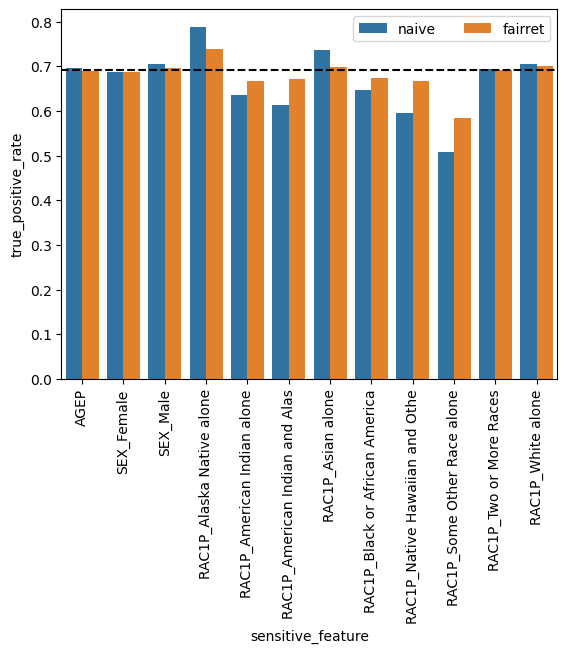

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

short_sens_cols = [col[:30] for col in sens_cols]
df = pd.DataFrame({
    'kind': ['naive'] * len(sens_cols) + ['fairret'] * len(sens_cols),
    'true_positive_rate': np.concatenate([naive_stat_per_group.detach(), stat_per_group.detach()]),
    'sensitive_feature': np.concatenate([short_sens_cols, short_sens_cols])
})
sns.barplot(data=df, x='sensitive_feature', y='true_positive_rate', hue='kind')
plt.axhline(y=overall_stat, color='black', linestyle='--')
plt.gca().tick_params(axis='x', rotation=90)
plt.legend(ncols=2)
